<a href="https://colab.research.google.com/github/AadityaAdh/Traffic_sign_recognition/blob/main/aaaugumentations.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import albumentations as alb
import cv2
import matplotlib.pyplot as plt
import os
import json
import numpy as np

In [3]:
augmentor = alb.Compose([alb.RandomCrop(width=224, height=224),
                         alb.RandomBrightnessContrast(p=0.2),
                         alb.RandomGamma(p=0.2),
                         alb.RGBShift(p=0.2)],
                       bbox_params=alb.BboxParams(format='albumentations',
                                                  label_fields=['class_labels']))

In [4]:
for folder in ['train','valid']:
    for file in os.listdir(os.path.join('/content','drive','MyDrive','data',folder,'images')):
        file_arr=file.split('.')
        extension=file_arr[1]
        if(extension=='JPG'):
            img=cv2.imread(os.path.join('/content','drive','MyDrive','data',folder,'images',file))
            label_file=os.path.join('/content','drive','MyDrive','data',folder,'labels',f'{file_arr[0]}.json')
            #below two line for no face in image
            my_label=[0]
            coords = [0,0,0.00001,0.00001]
            if os.path.exists(label_file):
                with open(label_file, 'r') as f:
                    my_json_file=json.load(f)
                    #print(my_json_file['shapes'][0]['points'])
                    if(my_json_file['shapes'][0]['label']=="Aaditya"):
                        my_label=[1]
                        #print(1)
                    coords[0] = my_json_file['shapes'][0]['points'][0][0]
                    coords[1] = my_json_file['shapes'][0]['points'][0][1]
                    coords[2] = my_json_file['shapes'][0]['points'][1][0]
                    coords[3] = my_json_file['shapes'][0]['points'][1][1]
                    coords = list(np.divide(coords, [1280,720,1280,720]))
            try:
                for x in range(30):
                    augmented = augmentor(image=img, bboxes=[coords], class_labels=my_label)
                    cv2.imwrite(os.path.join('/content','drive','MyDrive','aug_data', folder, 'images', f'{file.split(".")[0]}.{x}.JPG'), augmented['image'])

                    annotation={}
                    annotation['image']=file
                    if os.path.exists(label_file):
                        if len(augmented['bboxes']) == 0:
                            #yo case vanae ko albumnetation garda resize haru zoom haru vayae ra vako face pani
                            #image bata hatna sakxa tesko lagi ho
                            #so no face ko class dini
                            annotation['bbox'] = [0,0,0,0]
                            annotation['class'] = "no_sign"
                        else:
                            annotation['bbox'] = augmented['bboxes'][0]
                            annotation['class']=my_json_file['shapes'][0]['label']

                    else:
                        #this  the case of pailei kunai face xaina
                        annotation['bbox'] = [0,0,0,0]
                        annotation['class'] = "no_sign"

                    with open(os.path.join('/content','drive','MyDrive','aug_data', folder, 'labels', f'{file.split(".")[0]}.{x}.json'), 'w') as f:
                        json.dump(annotation, f)



            except Exception as e:
                print(e)









In [5]:
import tensorflow as tf
import cv2
import json
import matplotlib.pyplot as plt

In [6]:
def load_image(x):
    byte_img = tf.io.read_file(x)
    img = tf.io.decode_jpeg(byte_img)
    return img

In [7]:
train_images=tf.data.Dataset.list_files('/content/drive/MyDrive/aug_data/train/images/*.JPG',shuffle=False)
train_images = train_images.map(load_image)
train_images = train_images.map(lambda x: tf.image.resize(x, (120,120)))
train_images = train_images.map(lambda x: x/255)


In [8]:
val_images=tf.data.Dataset.list_files('/content/drive/MyDrive/aug_data/valid/images/*.JPG',shuffle=False)
val_images = val_images.map(load_image)
val_images = val_images.map(lambda x: tf.image.resize(x, (120,120)))
val_images = val_images.map(lambda x: x/255)


In [9]:
def load_labels(x):
    label_file = x.numpy().decode("utf-8")
    with open(label_file, "r") as f:
        my_json_object = json.load(f)
        label = my_json_object["class"].lower()
        if label == "thirty":
            return tf.constant([1,0,0,0,0,0,0,0,0,0,0,0,0,0,0], dtype=tf.float32)
        elif label == "fifty":
            return tf.constant([0,1,0,0,0,0,0,0,0,0,0,0,0,0,0], dtype=tf.float32)
        elif label == "children":
            return tf.constant([0,0,1,0,0,0,0,0,0,0,0,0,0,0,0], dtype=tf.float32)
        elif label == "left_turning":
            return tf.constant([0,0,0,1,0,0,0,0,0,0,0,0,0,0,0], dtype=tf.float32)
        elif label == "no_entry":
            return tf.constant([0,0,0,0,1,0,0,0,0,0,0,0,0,0,0], dtype=tf.float32)
        elif label == "no_horn":
            return tf.constant([0,0,0,0,0,1,0,0,0,0,0,0,0,0,0], dtype=tf.float32)
        elif label == "no_parking":
            return tf.constant([0,0,0,0,0,0,1,0,0,0,0,0,0,0,0], dtype=tf.float32)
        elif label == "no_stopping":
            return tf.constant([0,0,0,0,0,0,0,1,0,0,0,0,0,0,0], dtype=tf.float32)
        elif label == "right_turning":
            return tf.constant([0,0,0,0,0,0,0,0,1,0,0,0,0,0,0], dtype=tf.float32)
        elif label == "slope":
            return tf.constant([0,0,0,0,0,0,0,0,0,1,0,0,0,0,0], dtype=tf.float32)
        elif label == "straight_or_left":
            return tf.constant([0,0,0,0,0,0,0,0,0,0,1,0,0,0,0], dtype=tf.float32)
        elif label == "straight_or_right":
            return tf.constant([0,0,0,0,0,0,0,0,0,0,0,1,0,0,0], dtype=tf.float32)
        elif label == "uturn":
            return tf.constant([0,0,0,0,0,0,0,0,0,0,0,0,1,0,0], dtype=tf.float32)
        elif label == "zebra":
            return tf.constant([0,0,0,0,0,0,0,0,0,0,0,0,0,1,0], dtype=tf.float32)
        elif label == "no_sign":
            return tf.constant([0,0,0,0,0,0,0,0,0,0,0,0,0,0,1], dtype=tf.float32)




In [10]:
train_labels = tf.data.Dataset.list_files('/content/drive/MyDrive/aug_data/train/labels/*.json', shuffle=False)
train_labels=train_labels.map(lambda x :tf.py_function(load_labels,[x],tf.float32))

In [11]:
val_labels = tf.data.Dataset.list_files('/content/drive/MyDrive/aug_data/valid/labels/*.json', shuffle=False)
val_labels=val_labels.map(lambda x :tf.py_function(load_labels,[x],tf.float32))

In [12]:
len(train_images)

16770

In [13]:
len(train_labels)

16770

In [14]:
len(val_images)

3630

In [15]:
len(val_labels)

3630

In [32]:
train = tf.data.Dataset.zip((train_images, train_labels))
train = train.shuffle(5000)
train = train.batch(64)
train = train.prefetch(32)

In [33]:
val = tf.data.Dataset.zip((val_images, val_labels))
val = val.shuffle(1000)
val = val.batch(64)
val = val.prefetch(32)

In [47]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense, Dropout,InputLayer,BatchNormalization


model1=tf.keras.Sequential([
    InputLayer((120,120,3)),
    Conv2D(filters=32,kernel_size=3,strides=1,padding="same",activation="relu"),
    BatchNormalization(),
    Conv2D(filters=32,kernel_size=3,strides=1,padding="same",activation="relu"),
    BatchNormalization(),
    MaxPool2D(pool_size=2,strides=2),
    Dropout(0.3),


    Conv2D(filters=64,kernel_size=3,strides=1,padding="same",activation="relu"),
    BatchNormalization(),
    Conv2D(filters=64,kernel_size=3,strides=1,padding="same",activation="relu"),
    BatchNormalization(),
    MaxPool2D(pool_size=2,strides=2),
    Dropout(0.3),



    Conv2D(filters=128,kernel_size=3,strides=1,padding="same",activation="relu"),
    BatchNormalization(),
    Conv2D(filters=128,kernel_size=3,strides=1,padding="same",activation="relu"),
    BatchNormalization(),
    MaxPool2D(pool_size=2,strides=2),
    Dropout(0.3),


    Conv2D(filters=256,kernel_size=3,strides=1,padding="same",activation="relu"),
    BatchNormalization(),
    Conv2D(filters=256,kernel_size=3,strides=1,padding="same",activation="relu"),
    BatchNormalization(),
    MaxPool2D(pool_size=2,strides=2),
    Dropout(0.3),







    Flatten(),



    Dense(1024,activation="relu"),
    Dropout(0.5),


    Dense(15,activation="softmax")
])


model1.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_32 (Conv2D)          (None, 120, 120, 32)      896       
                                                                 
 batch_normalization_32 (Ba  (None, 120, 120, 32)      128       
 tchNormalization)                                               
                                                                 
 conv2d_33 (Conv2D)          (None, 120, 120, 32)      9248      
                                                                 
 batch_normalization_33 (Ba  (None, 120, 120, 32)      128       
 tchNormalization)                                               
                                                                 
 max_pooling2d_16 (MaxPooli  (None, 60, 60, 32)        0         
 ng2D)                                                           
                                                      

In [48]:
from tensorflow.keras.optimizers import Adam,SGD
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.metrics import Accuracy




In [49]:
optimizer = SGD(learning_rate=0.01, momentum=0.9)

In [50]:
model1.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'],run_eagerly=True)

In [42]:
history=model1.fit(train,validation_data=val,epochs=10,verbose=1)

Epoch 1/10
263/263 [==============================] - 296s 993ms/step - loss: 0.1493 - accuracy: 0.9673 - val_loss: 1.9789 - val_accuracy: 0.7394
Epoch 2/10
263/263 [==============================] - 169s 517ms/step - loss: 0.0090 - accuracy: 0.9976 - val_loss: 1.6766 - val_accuracy: 0.7824
Epoch 3/10
263/263 [==============================] - 164s 514ms/step - loss: 0.0074 - accuracy: 0.9981 - val_loss: 1.3328 - val_accuracy: 0.7835
Epoch 4/10
263/263 [==============================] - 163s 506ms/step - loss: 0.0043 - accuracy: 0.9986 - val_loss: 1.7437 - val_accuracy: 0.7722
Epoch 5/10
263/263 [==============================] - 163s 511ms/step - loss: 0.0026 - accuracy: 0.9995 - val_loss: 1.7525 - val_accuracy: 0.7617
Epoch 6/10
263/263 [==============================] - 161s 505ms/step - loss: 0.0037 - accuracy: 0.9993 - val_loss: 1.6309 - val_accuracy: 0.7598
Epoch 7/10
263/263 [==============================] - 168s 530ms/step - loss: 7.7610e-04 - accuracy: 0.9998 - val_loss: 1.42

In [43]:
model1.save('/content/drive/MyDrive/collabone.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [44]:
model1.save('/content/drive/My Drive/collabone.keras')

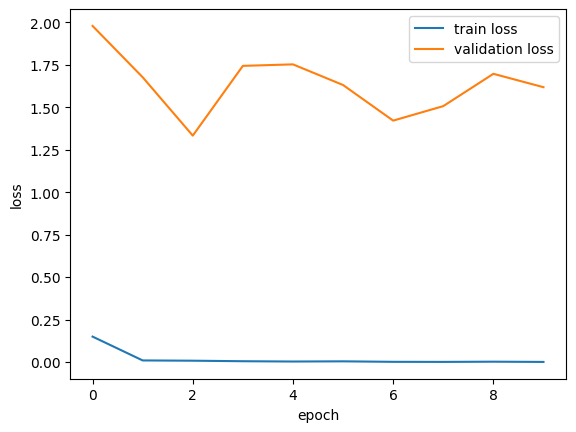

In [45]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['train loss','validation loss'])
plt.ylabel("loss")
plt.xlabel("epoch")
plt.show()


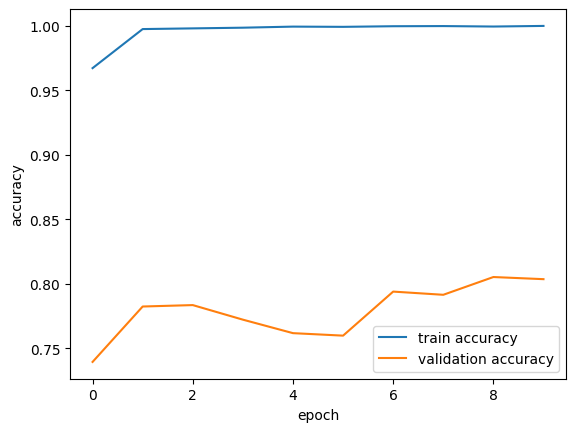

In [46]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['train accuracy','validation accuracy'])
plt.ylabel("accuracy")
plt.xlabel("epoch")
plt.show()
